## SVM

In [45]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Loading pre-elaborated datas
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')

# Loading class weighting
class_weights_dict = np.load('Pre_Processed_Data/class_weights.npy', allow_pickle=True).item()

# Create an instance of the SVM model with kernel RBF

In [46]:
svm = SVC(kernel='rbf')

# Specify search space for hyperparameters

In [47]:
search_space = [Real(0.1, 10, name='C'), Real(0.1, 10, name='gamma')]

# Definition of an objective function to minimize

In [48]:
@use_named_args(search_space)
def objective(C, gamma):
    # Create an instance of the SVM model with kernel RBF using the current hyperparameters
    svm = SVC(class_weight=class_weights_dict, kernel='rbf', C=C, gamma=gamma)

    # Train the model using the training set
    svm.fit(train_features, train_labels)

    # Evaluate model performance on validation set
    y_val_pred = svm.predict(val_features)
    val_accuracy = accuracy_score(val_labels, y_val_pred)

    # Restituisci l'errore di validazione (1 - accuracy) come valore da minimizzare
    return 1 - val_accuracy

# Perform Bayesian optimization to find the best hyperparameters

In [59]:
result = gp_minimize(objective, search_space)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python

# Printing the best hyperparameters found by Bayesian optimization

In [50]:
best_params = {param.name: value for param, value in zip(search_space, result.x)}
print(f'Best hyperparameters: {best_params}')

Best hyperparameters: {'C': 8.607468836913567, 'gamma': 0.21798435087813556}


# So, now we can instantiate SVM model with RBF kernel using best hyperparameters found by Bayesian optimization

In [51]:
svm = SVC(class_weight=class_weights_dict, kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])

# Training the model the training set

In [52]:
svm.fit(train_features, train_labels)

SVC(C=8.607468836913567,
    class_weight={0: 0.7660714285714286, 1: 1.4395973154362416},
    gamma=0.21798435087813556)

# Now we use the trained model to make predictions about the test set

In [53]:
test_predictions = svm.predict(test_features)
print(test_predictions)

[0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0
 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0
 0 0 0 1 0 0 1 0 0]


## Performance evaluation on test set

In [54]:
# Valuta le prestazioni del modello sul set di test
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy on test set: {test_accuracy:.2f}')

Accuracy on test set: 0.72


## Compute confusion matrix

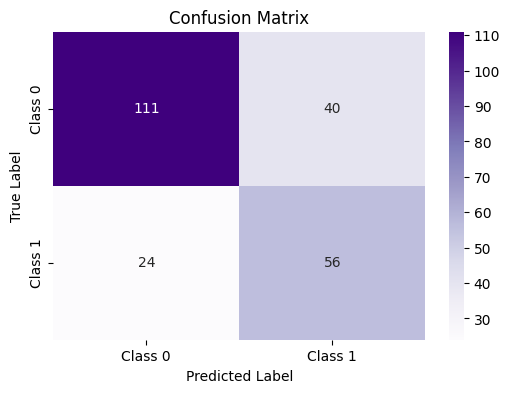

In [55]:
cm = confusion_matrix(test_labels, test_predictions)

# Define class labels
class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report

In [56]:
report = classification_report(test_labels, test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       151
           1       0.58      0.70      0.64        80

    accuracy                           0.72       231
   macro avg       0.70      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231



# ROC and AUC

AUC: 0.7175496688741722


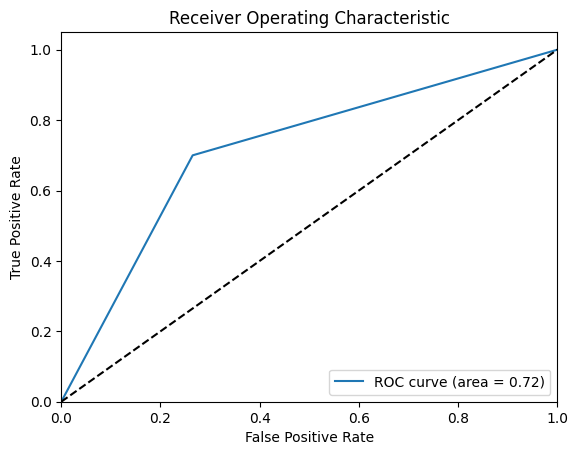

In [57]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_predictions)

# Print AUC
print("AUC:", auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Cross Validation

In [58]:
# Performing cross-validation
scores = cross_val_score(svm, train_features, train_labels, cv=5)

# Calculation of the average of the accuracy scores
mean_accuracy = scores.mean()

# Printing the accuracy scores obtained for each fold
print("Accuracy scores for each fold:", scores)

# Printing mean accuracy of kv
print("Mean accuracy:", mean_accuracy)

Accuracy scores for each fold: [0.79069767 0.70930233 0.75581395 0.76744186 0.83529412]
Mean accuracy: 0.7717099863201095
